# Component inference and model families 

This notebook shows a series of examples of how to use model families and component inference with PCM.

In [1]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.io as io

## Example 1: Simple 3 x 2 Design
This is a classical example of a fully crossed design with two factors (A and B) and the possibility for an interaction between those two factors. A experimental example would be that you measure the response to 6 stimuli, with 3 different objects in two different colors. You want to test whether a) objects are represented b) colors are represented c) the unique combination of color and object is represented. Thus, this is a MANOVA-like design where you want to test for the main effects of A and B, as well as their interaction. 

*Note: When building the features for the 3 different components, the interaction usually has to the orthogonalized for the main effects. If the interaction is not orthogonalized, the interaction effect can explain part of the variance explained by the main effects. Try out what happens when you use the non-orthogonalized version of the interaction effect - you will see that a Model Family deals correctly with this situation as well!* 

#### Generating data from a 3x2 Design
Note that for data generation, we consider the interaction fixed - meaning that when the interaction effect is present, no difference between categories of A and B occur. 

In [10]:
# Generate the three model components, each one as a fixed model
A = np.array([[1.0,0,0],[1,0,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]])
B = np.array([[1.0,0],[0,1],[1,0],[0,1],[1,0],[0,1]])
I = np.eye(6)
# Orthogonalize the interaction effect
X= np.c_[A,B]
Io = I-X @ np.linalg.pinv(X) @ I

# Now Build the second moment matrix and create the full model 
# for data generation: 
Gc = np.zeros((3,6,6))
Gc[0]=A@A.T
Gc[1]=B@B.T
Gc[2]=Io@Io.T

trueModel = pcm.ComponentModel('A+B+I',Gc)


Now generate 20 data set from the full model. 
The vector `theta` gives you the log-variance of the A,B, and Interaction components. Here A is absent, and the interaction stronger than the B-effect. 
You can play around with the values to check out other combinations. 

In [13]:
[cond_vec,part_vec]=pcm.sim.make_design(6,8)
theta = np.array([-np.inf,-1,0])
D = pcm.sim.make_dataset(trueModel,theta,
        signal=0.1,
        n_sim = 20,
        n_channel=20,
        part_vec=part_vec,
        cond_vec=cond_vec)

#### Building a model family

Now we construct a model family for all possible combinations 

*Note:Here you can decide whether to use the orthogonalized interaction effect or not*

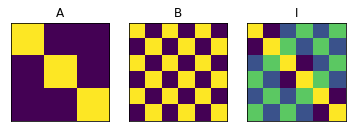

In [14]:
# Use orthogonlized interaction effect 
Gc[2]=Io@Io.T
MF=pcm.model.ModelFamily(Gc,comp_names=['A','B','I'])

# Show the three model components
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(Gc[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(MF.comp_names[i])

#### Fitting the data 
Now we can fit the data with the entire model family. An intercept is added as a fixed effect for each partition (block) seperately, as common for fMRI data. The result is a likelihood for each of the model combination. 

<AxesSubplot:xlabel='model', ylabel='Log Bayes Factor'>

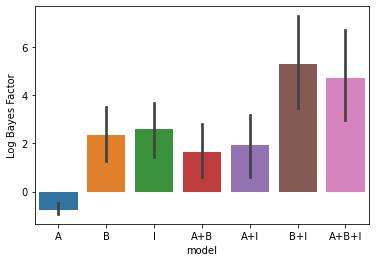

In [5]:
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block', fit_scale=False)
# Here we correcting for the number of parameters (using AIC)
pcm.vis.model_plot(T.likelihood-MF.num_comp_per_m)

#### Inference: Model posterior
For the inference, we can use either crossvalidated pseudo-likelihoods (within- subject or between subjects - see inference), or we can use the fitted likelihood, correcting for the number of paramaters using an AIC approach. We use latter approach here. 

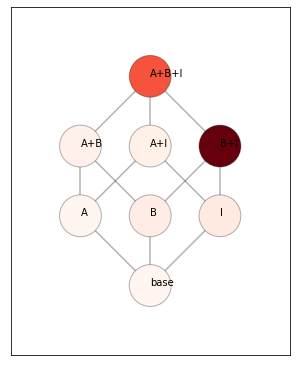

In [6]:
# We can computer the posterior probability of each of the mixture models. 
# This uses the flat prior over all possible model combinations 
# The whole model family can visualized as a model tree.  
plt.figure(figsize=(5,7))
# Get the mean likelihood 

mposterior = MF.model_posterior(T.likelihood.mean(axis=0),method='AIC',format='DataFrame')
pcm.vis.plot_tree(MF,mposterior,show_labels=True,show_edges=True)
# mposterior.to_numpy()

#### Inference: Component posterior
We can also get the posterior probability for each component. This is simply the sum of the posterior probabilties of all the model combinations that contain that component. The 0.5 line (this is the prior probability) is drawn. The lower line is the most evidence we can get for the absence of a model component using AIC. This is because, in the worst case, a new component does not increase the likelihood at all. This would result in the new component having a realtive likelihood that is 1.0 lower than the simpler model (parameter penality). Thus, overall the worst we can get p=1/(1+exp(1)).

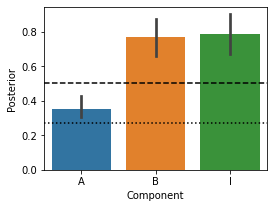

In [7]:

# Component posterior
plt.figure(figsize=(4,3))
cposterior = MF.component_posterior(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(cposterior,type='posterior')


#### Component Bayes factor 
For frequentist statistical testing and display, it is also often useful use the log-odds of the posterior $log(p/(1-p))$. For a flat prior across the model family, this is the bayes factor for the specific component. 

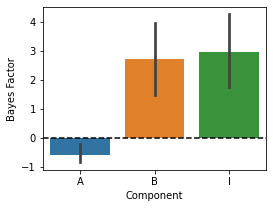

In [8]:
# Component Bayes Factor 
plt.figure(figsize=(4,3))
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')

#### Base components
Often, there are components in a Model family that we always want to have in our model - these can be specified as "base components". By default (i.e. no base components are specified), the base model will be the zero model (there are no differences between any of the patterns).
In this example, we add a strong pattern that predicts that pattern 1-3 and pattern 4-6 are correlated. 

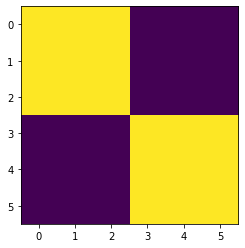

In [15]:
basecomp = np.zeros((1,6,6))
basecomp[0] = np.block([[np.ones((3,3)),np.zeros((3,3))],[np.zeros((3,3)),np.ones((3,3))]])
plt.imshow(basecomp[0])

In [35]:
trueModel = pcm.ComponentModel('A+B+I+basecomponent',np.r_[Gc,basecomp])

# Now generate 20 data set from the full model 
[cond_vec,part_vec]=pcm.sim.make_design(6,8)
# Interaction effect and base component are present 
theta = np.array([-np.inf,-np.inf,0,0])
D = pcm.sim.make_dataset(trueModel,theta,
        signal=0.1,
        n_sim = 20,
        n_channel=20,part_vec=part_vec,
        cond_vec=cond_vec)

First we fit this data with a model without the base component. You will see that the base-effect mimics as the main effect A and gives us a false positive - component A is not really present.

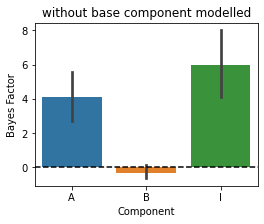

In [23]:
MF=pcm.model.ModelFamily(Gc,comp_names=['A','B','I'])
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block',fit_scale=False)

# Component Bayes Factor
plt.figure(figsize=(4,3))
plt.title('without base component modelled')
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')

Now we are adding the base component to all the models - so all models fitted will contain this extra component. 

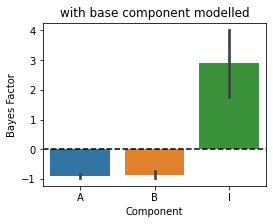

In [25]:
MF=pcm.model.ModelFamily(Gc,comp_names=['A','B','I'],basecomponents=basecomp)
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block',fit_scale=False)

# Component Bayes Factor
plt.figure(figsize=(4,3))
plt.title('with base component modelled')
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')

Now the inference is correct again. So if you have a strong correlation structure in your data that needs to be modeled (but that you do not want to draw inferences on), add it as a base component!

## Example 2: Random example with 5 partly co-linear representations
In this example, we provide an example with random components that are partly overlapping with each other. 
We also provide a function that performs different forms of component inference.

In [37]:
# Another function that makes a random feature model 
# using Q feature groups (components), each consisting of num_feat features. 
def random_design(N=10,Q=5,num_feat=2,seed=1):
    Gc = np.empty((Q,N,N))
    rng = np.random.default_rng(seed)
    for q in range(Q):
        X= rng.normal(0,1,(N,num_feat))
        X = X/np.sqrt(np.sum(X**2,axis=0))
        Gc[q,:,:]= X @ X.T
    M = pcm.ComponentModel('full',Gc)
    MF=pcm.model.ModelFamily(Gc)
    return M,MF

In [38]:
def component_inference(D,MF):
    T,theta=pcm.fit_model_individ(D,MF,verbose=False)

    # pcm.vis.model_plot(T.likelihood-MF.num_comp_per_m)
    mposterior = MF.model_posterior(T.likelihood.mean(axis=0),method='AIC',format='DataFrame')
    cposterior = MF.component_posterior(T.likelihood,method='AIC',format='DataFrame')
    c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')

    fig=plt.figure(figsize=(18,3.5))
    plt.subplot(1,3,1)
    pcm.vis.plot_tree(MF,mposterior,show_labels=False,show_edges=True)
    ax=plt.subplot(1,3,2)
    pcm.vis.plot_component(cposterior,type='posterior')
    ax=plt.subplot(1,3,3)
    pcm.vis.plot_component(c_bf,type='bf')


Now we make an example with 5 component and 10 conditions...

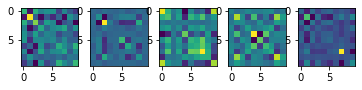

In [39]:
# make and plot a random design 
N = 10
Q = 5
M,MF = random_design(N=N,Q=Q,seed=1)
for q in range(Q):
        plt.subplot(1,Q,q+1)
        plt.imshow(M.Gc[q,:,:])


In [12]:
# Let's check the co-linearity of these particular components by looking at their correlation 
GG = np.reshape(M.Gc,(Q,-1)) # Flatten out 
np.corrcoef(GG)

array([[1.        , 0.24581198, 0.05609763, 0.3498265 , 0.42614867],
       [0.24581198, 1.        , 0.10612771, 0.20962178, 0.24458923],
       [0.05609763, 0.10612771, 1.        , 0.05158634, 0.3199829 ],
       [0.3498265 , 0.20962178, 0.05158634, 1.        , 0.15116567],
       [0.42614867, 0.24458923, 0.3199829 , 0.15116567, 1.        ]])

In this example, component 2 and 3 are relatively uncorrelated

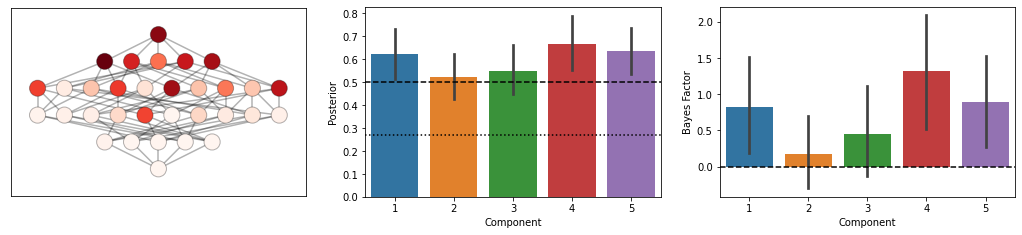

In [16]:
# Now make artifical data and plot component inference 
# In this example, component 1 and 4 are not present 
theta = np.array([-1,-1,-1,-1,-1])

[cond_vec,part_vec]=pcm.sim.make_design(N,8)
D = pcm.sim.make_dataset(M,theta,
                            signal=0.2,
                            n_sim = 20,
                            n_channel=20,part_vec=part_vec,
                            cond_vec=cond_vec)
component_inference(D,MF)
